In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import tensorflow as tf

import time

import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

# Generating Reber strings

### Defining the grammer
<img src='misc/reber.jpg'>

In [4]:
default_reber_grammer=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [("X", 5), ("S", 2)], # (state 2) =X=> (state 5) or =S=> (state 2)
    [("T", 3), ("V", 4)], # (state 3) =T=> (state 3) or =V=> (state 4)
    [("V", 6), ("P", 5)], # (state 4) =V=> (state 6) or =P=> (state 5)
    [("X",3), ("S", 6)],  # (state 5) =X=> (state 3) or =S=> (state 6)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

### Embedded Reber Grammar
<img src="misc/embedded.gif">

In [5]:
embedded_reber_grammer=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [(default_reber_grammer,4)], # (state 2) =REBER=> (state 4)
    [(default_reber_grammer,5)], # (state 3) =REBER=> (state 5)
    [("P", 6)], # (state 4) =P=> (state 6)
    [("T",6)],  # (state 5) =T=> (state 3)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

### Generating data

In [6]:
def generate_valid_strings(grammar):
    state = 0
    output = []
    while state is not None:
        char, state = grammar[state][np.random.randint(len(grammar[state]))]
        if isinstance(char, list):  # embedded reber
            char = generate_valid_strings(char)
        output.append(char)
    return "".join(output)

In [7]:
def generate_corrupted_strings(grammar, chars='BTSXPVE'):
    '''Substitute one character to violate the grammar'''
    good_string = generate_valid_strings(grammar)
    idx = np.random.randint(len(good_string))
    good_char = good_string[idx]
    bad_char = np.random.choice(sorted(set(chars)-set(good_char)))
    return good_string[:idx]+bad_char+good_string[idx+1:]

In [8]:
chars='BTSXPVE'
chars_dict = {a:i for i,a in enumerate(chars)}
chars_dict

{'B': 0, 'E': 6, 'P': 4, 'S': 2, 'T': 1, 'V': 5, 'X': 3}

In [9]:
def str2onehot(string, num_steps=12, chars_dict=chars_dict):
    res = np.zeros((num_steps, len(chars_dict)))
    for i in range(min(len(string), num_steps)):
        c = string[i]
        res[i][chars_dict[c]] = 1
    return res

In [10]:
def generate_data(data_size=10000, grammar=embedded_reber_grammer, num_steps=None):
    strings = dict()
    seq_lens = np.zeros(data_size, dtype=np.int32)
    y = np.zeros(data_size)
    for l, g in enumerate([generate_corrupted_strings, generate_valid_strings]):
        for i in range(data_size//2):
            k = i+data_size*l//2
            string = g(grammar)
            strings[k] = string
            seq_lens[k] = len(string)
            y[k] = l
    
    if num_steps is None:
        num_steps = max(seq_lens)
    # shuffle the data
    X = np.array([str2onehot(strings[i], num_steps=num_steps) for i in sorted(strings)])
    idx = np.random.permutation(data_size)
    X, seq_lens, y = [a[idx] for a in [X, seq_lens, y]]
    return X, seq_lens, y, num_steps

In [11]:
X_train, seq_lens_train, y_train, num_steps = generate_data(10000)
X_test, seq_lens_test, y_test, _ = generate_data(1000, num_steps=num_steps)
X_train.shape, seq_lens_train.shape, y_train.shape

((10000, 38, 7), (10000,), (10000,))

## Define the graph

In [12]:
num_inputs = len(chars)
num_neurons = 32
num_outputs = 1  # reber or not
num_epochs = 500

In [13]:
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(tf.float32, [None, num_steps, num_inputs])
    seq_lens = tf.placeholder(tf.int32, [None])
    y = tf.placeholder(tf.float32, [None, num_outputs])
    keep_prob = tf.placeholder_with_default(0.5, None, name='keep_prob')
    
    with tf.name_scope("Model"):
#         gru_cell = tf.contrib.rnn.GRUCell(num_neurons)
        gru_cell = tf.contrib.rnn.DropoutWrapper(
            tf.contrib.rnn.GRUCell(num_neurons), input_keep_prob=keep_prob)
        outputs, states = tf.nn.dynamic_rnn(gru_cell, X, seq_lens, dtype=tf.float32)
    
    with tf.name_scope("logits"):
        logits = tf.layers.dense(states, num_outputs)
    
    with tf.name_scope("optimization"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))

        optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    
    with tf.name_scope("Evaluation"):
        predictions = tf.cast(tf.greater(logits, 0.), tf.float32, name="predicitons")
        correct = tf.equal(predictions, y)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [14]:
def generate_batch(X, y, seq_lens, batch_size=50):
    i = 0
    while True:
        i += batch_size
        if i>len(X):
            i = batch_size
        yield X[i-batch_size:i,:,:], y[i-batch_size:i], seq_lens[i-batch_size:i]

In [15]:
def run_session(graph, num_epochs=1000, p_every=1, batch_size=50):
    start = time.time()
    generator = generate_batch(X_train, y_train, seq_lens_train, batch_size)
    with tf.Session(graph=graph) as sess:
        with tf.device('/gpu'):
            init.run()
            train_accuracies = dict()
            test_accuracies = dict()
            losses = dict()
            avg_loss = 0
            cntr = len(X_train)//batch_size
            for e in range(num_epochs+1):
                for i in range(cntr):
                    X_batch, y_batch, seq_lens_batch = generator.__next__()
                    feed_dict = {X:X_batch, seq_lens:seq_lens_batch, y: y_batch.reshape(-1, 1), keep_prob:0.5}
                    _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
                    avg_loss += loss_val
                avg_loss/= cntr
                if e%p_every == 0:
                    train_accuracy = accuracy.eval(
                        feed_dict = {X:X_train, seq_lens:seq_lens_train, y: y_train.reshape(-1, 1), keep_prob:1.0})

                    test_accuracy = accuracy.eval(
                                             feed_dict={X:X_test,
                                                        seq_lens:seq_lens_test,
                                                        y:y_test.reshape(-1, 1),
                                                        keep_prob:1})

                    losses[e] = avg_loss/p_every if e>0 else avg_loss
                    train_accuracies[e] = train_accuracy
                    test_accuracies[e] = test_accuracy

                    print("Epoch {0}:\nCross_entropy: {1}\nTrain accuracy: {2}\nTest accuracy: {3}".format(
                    e, avg_loss/10 if e>0 else avg_loss, train_accuracy, test_accuracy))
                    print("~"*30)
                avg_loss = 0
                    
            print("Took: ", time.time()-start)
            saver.save(sess,('./reber'))
        

        fig, ax1 = plt.subplots(figsize=(12,7))
        xticks = sorted(losses.keys())
        data1_valid = [train_accuracies[i] for i in xticks]
        data1_test = [test_accuracies[i] for i in xticks]
        data2 = [losses[i] for i in xticks]

        color = 'tab:blue'
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy', color=color)
        ax1.plot(xticks, data1_valid, color=color)
        ax1.plot(xticks, data1_test, color='tab:green')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Cross-entropy loss', color=color)
        ax2.plot(xticks, data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax1.legend(['Train. accuracy', 'test. accuracy'], loc='lower center')
        ax2.legend(['Train Cross-entropy loss'], loc='upper left')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped

Epoch 0:
Cross_entropy: 0.6909954577684403
Train accuracy: 0.6266999840736389
Test accuracy: 0.6309999823570251
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1:
Cross_entropy: 0.06866422563791275
Train accuracy: 0.6068000197410583
Test accuracy: 0.5740000009536743
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2:
Cross_entropy: 0.06804785639047622
Train accuracy: 0.6542999744415283
Test accuracy: 0.6399999856948853
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3:
Cross_entropy: 0.06743448561429978
Train accuracy: 0.6557000279426575
Test accuracy: 0.6209999918937683
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4:
Cross_entropy: 0.06645154792070389
Train accuracy: 0.6802999973297119
Test accuracy: 0.6470000147819519
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5:
Cross_entropy: 0.06597066277265548
Train accuracy: 0.6913999915122986
Test accuracy: 0.6800000071525574
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6:
Cross_entropy: 0.064974456012249
Train accuracy: 0.7228999733924866
Test accuracy: 0.7009999752044678
~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 57:
Cross_entropy: 0.05285588908195495
Train accuracy: 0.8073999881744385
Test accuracy: 0.8040000200271606
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 58:
Cross_entropy: 0.052423387378454214
Train accuracy: 0.8235999941825867
Test accuracy: 0.8119999766349792
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 59:
Cross_entropy: 0.052222503960132595
Train accuracy: 0.8191999793052673
Test accuracy: 0.8069999814033508
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60:
Cross_entropy: 0.05186066329479218
Train accuracy: 0.8845999836921692
Test accuracy: 0.8769999742507935
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 61:
Cross_entropy: 0.05203609579801559
Train accuracy: 0.8385000228881836
Test accuracy: 0.8240000009536743
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 62:
Cross_entropy: 0.051701905369758605
Train accuracy: 0.8529999852180481
Test accuracy: 0.8399999737739563
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 63:
Cross_entropy: 0.05186795020103454
Train accuracy: 0.8475000262260437
Test accuracy: 0.8360000252723694
~~~~~~~~~~~~~

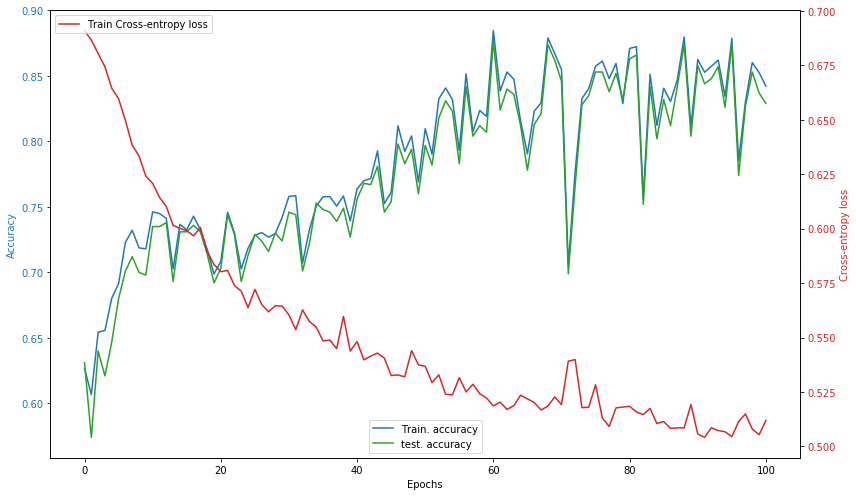

In [16]:
run_session(graph, num_epochs=100, batch_size=100)